# PART A: 20-NEWSGROUPS [60 POINTS]
**This dataset is a collection of approximately 20,000 newsgroup documents, partitioned
(nearly) evenly across 20 dierent newsgroups, each corresponding to a dierent topic.
If you look at the topics, you may notice that they group together under some general
headings.
In order to make the problem more manageable, we will only use 8 out of the full 20
dierent groups. These are numbered sequentially :
0.
1.
2.
3.
4.
5.
6.
7.
comp.sys.ibm.pc.hardware
,
,
comp.sys.mac.hardware
rec.autos
,
rec.motorcycles
sci.crypt
,
,
sci.electronics
,
soc.religion.christian
talk.religion.misc
, and
.
In contrast to Assignment 1, we have opted to use Term-Frequency/Inverse-Document
Frequency TF-IDF weights for each word instead of the frequency counts. These weights
represent the importance of a word to a document, with respect to a collection of docu-
ments. The importance increases proportionally to the number of times a word appears
in the document, and is inversely proportional to the number of times the word appears
in the whole corpus.

In [225]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import adjusted_mutual_info_score, f1_score
%matplotlib inline

# Question 1 : (10 points) Exploratory Analysis

In [2]:
# Load the dataset into train samples+labels, test samples+labels and dataset labels.
data_path = os.path.join(os.getcwd(), "Data/PartA", "20ng_train.csv")
NG_train_samples = pd.read_csv(data_path, compression="bz2")
NG_train_labels = NG_train_samples['class']
NG_train_samples.drop('class', axis=1, inplace=True)

data_path = os.path.join("Data/PartA", "20ng_test.csv")
NG_test_samples = pd.read_csv(data_path, compression="bz2")
NG_test_labels = NG_test_samples['class']
NG_test_samples.drop('class', axis=1, inplace=True)

data_path = os.path.join("Data/PartA", "20ng_labels.csv")
NG_labels = pd.read_csv(data_path, compression="bz2")

In [82]:
# Describe the TRAINING dataset
print("NG_train shape: {} \n".format(NG_train_samples.shape))

print("Class labels & distribution:")
for i in range(NG_labels.size):
    print("{} count: {}".format(NG_labels.values[i], (sum(NG_train_labels == i))/len(NG_train_labels)))
NG_train_samples.describe()

NG_train shape: (5648, 1000) 

Class labels & distribution:
['comp.sys.ibm.pc.hardware'] count: 0.1304886685552408
['comp.sys.mac.hardware'] count: 0.1278328611898017
['rec.autos'] count: 0.13137393767705383
['rec.motorcycles'] count: 0.13225920679886685
['sci.crypt'] count: 0.13155099150141644
['sci.electronics'] count: 0.1306657223796034
['soc.religion.christian'] count: 0.13243626062322947
['talk.religion.misc'] count: 0.08339235127478753
5648


,__,ability,able,ac,accept,access,according,account,act,action,...,world,worth,wouldn,write,written,wrong,wrote,year,years,yes
count,5648.000000,5648.000000,5648.000000,5648.000000,5648.000000,5648.000000,5648.000000,5648.000000,5648.000000,5648.000000,...,5648.000000,5648.000000,5648.000000,5648.000000,5648.000000,5648.000000,5648.000000,5648.000000,5648.000000,5648.000000
mean,0.001708,0.001472,0.006335,0.002273,0.002466,0.004041,0.002923,0.001420,0.002057,0.001560,...,0.006102,0.003717,0.004887,0.003494,0.002800,0.006421,0.001851,0.006020,0.008144,0.006705
std,0.034360,0.016554,0.033866,0.026688,0.022362,0.030053,0.024208,0.018515,0.020301,0.020248,...,0.034573,0.028373,0.033153,0.027797,0.025441,0.037083,0.020132,0.036011,0.037727,0.039841
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.956585,0.443807,0.565277,0.711480,0.529982,0.635985,0.560049,0.461537,0.657318,0.631932,...,0.487020,0.614346,0.698880,0.511068,0.596214,0.751603,0.561412,0.617048,0.438414,0.736056


**[1.1] (5 points) Focusing first on the training set, summarise the key features/observations
in the data: focus on the dimensionality, data ranges, feature and class distribution and
report anything out of the ordinary. What are the typical values of the features like?**

The training set has 5684 samples with 1000 features each. The TF-IDF weights for each word are float values between 0 and 1. The classes are distributed almost evenly, with each class having between 12.7% - 13.2% of samples in the training set, with the exception of class 7 (talk.religion.misc) which has only 8.3% of samples.

The presence of a feature '__' is slightly out of the ordinary, since it is not a word.

Most cells have a value of 0, which is to be expected since most documents contain only a small percentage of words. If we exclude all non-zero values, then most words have an average TF-IDF weight of 0.17, with a standard deviation of 0.05. There are some words with a high TF-IDF value (over 0.4), such as: '__', 'dog', 'elohim', 'helmet', 'mov', 'ra'.




In [64]:
# Feature distribution:
a = []
for label in NG_train_samples.columns:
    x = NG_train_samples[label]
    a.append(np.mean(x[x> 0]))
    #print("{} non-zero mean value: {}".format(label, np.mean(x[x> 0])))
a = np.array(a)
print(np.mean(a))
print (np.std(a))
print(NG_train_samples.columns[np.argwhere(a>0.4)])

0.17172102495815147
0.052756410025995334
Index(['__', 'dog', 'elohim', 'helmet', 'mov', 'ra'], dtype='object')


'__'

In [83]:
# Describe the TESTING dataset
print("NG_test shape: {} \n".format(NG_test_samples.shape))

print("Class labels & distribution:")
for i in range(NG_labels.size):
    print("{} count: {}".format(NG_labels.values[i], (sum(NG_test_labels == i))/len(NG_test_labels)))
NG_test_samples.describe()

NG_test shape: (1883, 1000) 

Class labels & distribution:
['comp.sys.ibm.pc.hardware'] count: 0.13011152416356878
['comp.sys.mac.hardware'] count: 0.12798725438130643
['rec.autos'] count: 0.13170472650026555
['rec.motorcycles'] count: 0.13223579394583113
['sci.crypt'] count: 0.13170472650026555
['sci.electronics'] count: 0.13064259160913436
['soc.religion.christian'] count: 0.13223579394583113
['talk.religion.misc'] count: 0.08337758895379713


,__,ability,able,ac,accept,access,according,account,act,action,...,world,worth,wouldn,write,written,wrong,wrote,year,years,yes
count,1883.000000,1883.000000,1883.000000,1883.000000,1883.000000,1883.000000,1883.000000,1883.000000,1883.000000,1883.000000,...,1883.000000,1883.000000,1883.000000,1883.000000,1883.000000,1883.000000,1883.000000,1883.000000,1883.000000,1883.000000
mean,0.002292,0.002168,0.007335,0.002817,0.002701,0.004449,0.003012,0.001716,0.001886,0.001745,...,0.006194,0.003018,0.005356,0.003746,0.003812,0.007960,0.001970,0.006214,0.008706,0.009449
std,0.032391,0.021397,0.034312,0.032169,0.021777,0.032393,0.026133,0.022855,0.019504,0.018376,...,0.041170,0.026231,0.033441,0.028779,0.032836,0.039182,0.020613,0.037389,0.041551,0.043570
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.864159,0.469412,0.337561,0.620254,0.310053,0.504324,0.420903,0.632166,0.336667,0.387412,...,1.000000,0.490894,0.481298,0.434553,0.543384,0.470697,0.566179,0.537827,0.532047,0.590114


In [84]:
# Feature distribution:
a = []
for label in NG_test_samples.columns:
    x = NG_test_samples[label]
    a.append(np.mean(x[x> 0]))
    #print("{} non-zero mean value: {}".format(label, np.mean(x[x> 0])))
a = np.array(a)
print(np.mean(a))
print (np.std(a))
print(NG_test_samples.columns[np.argwhere(a>0.4)])

0.16859237721506934
0.05317875761998273
Index(['dog', 'elohim', 'fpu', 'nubus', 'ra', 'radar', 'simms'], dtype='object')


**[1.2] (3 points) Looking now at the Testing set, how does it compare with the Training
Set (in terms of sizes and feature-distributions) and what could be the repurcussions of
this?**

The Testing set is distributed almost equally to the Training set. It has 1883 samples, meaning that the dataset was split in 75%/25% for the training/testing sets. The feature distribution is similar: if we exclude all zero-values, then the mean TF-IDF weight accross all words is 0.168, with a standard deviation of 0.05.
Similarly, the classes are distributed in the same way as the training set.
Since the test and training data come from the same distribution, we expect the classifier to do fairly well on the testing set.
 

**[1.3] (2 points) Why do you think it is useful to consider TF-IDF weights as opposed to
just the frequency of times a word appears in a document as a feature?**

If we only considered Term Frequency (like in the Bag of Words model), then words such as "and", "the", "a" would always have a very high frequency, giving us the wrong impression that those words are very important in a document. However, the TF-IDF model also takes into account Inverse Document Frequency - meaning that for a word to be 'important', it shouldn't appear that often in other documents.
This makes our classifier more accurate, since it knows what the real 'signature words' of a document are.

# Question 2 : (24 points) Unsupervised Learning

**[2.1] (2 points) The K-Means algorithm is non-deterministic. Explain why this is, and
how the final model is selected in the SKLearn implementation of KMeans.**

The result of the K-means algorithm is highly dependent on the initialization of the centroids.
To address this, the SKLearn implementation of K-means runs the algorithm multiple times with different centroid seeds, specified in the "n_init" parameter (default: 10), and selects the best result in terms of inertia. Additionally, one can set the "init" parameter for selecting initial clusters to "k-means++", which seems to give better results than random initialization.

**[2.2] (1 point) One of the parameters we need to specify when using k-means is the number
of clusters. What is a reasonable number for this problem and why?**

It would be better to run the K-means model with K=1, 2, 3,... and then plot the resulting variances. Then we can choose the number of clusters that correspond to the "steepest elbow" (the point where the rate of decline changes the most)

**[2.3] (5 points) We will use the Adjusted Mutual Information (AMI) i.e. adjusted_mutual
_info_score between the clusters and the true (known) labels to quantify the performance of the clustering. Give an expression for the MI in terms of entropy. In short,
describe what the MI measures about two variables, why this is applicable here and why
it might be difficult to use in practice. Hint: MI is sometimes referred to as Information
Gain: note that you are asked only about the standard way we defined MI and not the
AMI which is adjusted for the size of the domain and for chance agreement.**

Mutual information can be equivalently expressed as:
I(X;Y) = H(X) + H(Y) - H(X,Y) where H(X) and H(Y) are the marginal entropies, and H(X,Y) is the joint entropy of X and Y.
The MI between two variables measures the "amount of information" obtained about one variable through observing the other variable.
We can apply MI in this model to measure the similarity between our clustering labels and the true labels, and thus quantify the performance of our clustering. However, this might be difficult to use in practice due to poorly understood bias/variance tradeoffs.

**[2.4] (4 points) Fit K-Means objects with n_clusters ranging from 2 to 12. Set the
random seed to 1000 and the number of initialisations to 50, but leave all other values
at default. For each fit compute the adjusted mutual information (there is an SKLearn
function for that). Set average_method=`max' . Plot the AMI scores against the number
of clusters (as a line plot).**

In [93]:
# Calculate AMI scores
AMIs = []
for n in range(2,13):
    kmeans = KMeans(n_clusters=n, random_state=1000, n_init=50)
    kmeans.fit(NG_train_samples)
    AMIs.append(adjusted_mutual_info_score(labels_true=NG_train_labels, labels_pred=kmeans.labels_, average_method='max'))


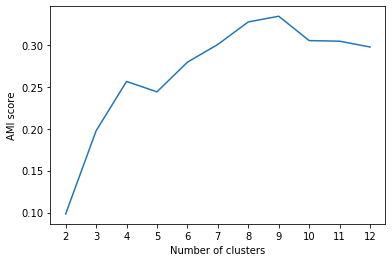

In [158]:
# Plot AMI scores against the number of clusters
df_AMI = pd.DataFrame(np.array(AMIs), columns=["AMI"], index=list(range(2,13)))
ax = sns.lineplot(data=df_AMI, legend=False)

plt.xlabel("Number of clusters")
plt.ylabel("AMI score")
plt.xticks(np.arange(2,13,1))

plt.show()

**[2.5] (3 points) Discuss any trends and interesting aspects which emerge from the plot.
Does this follow from your expectations?**

The AMI score is rapidly improving at first (2-4 clusters), and then slowly improving (5-9 clusters) until it reaches a peak at 9 clusters. The following iterations (9-12 clusters), decrease the AMI score, which could indicate that the model is 'overfitting'.

The peak at 9 clusters was to be expected, since the clusters end up closely matching the 8 classes present in the dataset. It is interesting that there is a drop in AMI score between 4 and 5 clusters. The rate of increase changes the most at 4 clusters.

**[2.6] (6 points) Let us investigate the case with four (4) clusters in some more detail.
Using seaborn's countplot function, plot a bar-chart of the number of data-points with a
particular class (encoded by colour) assigned to each cluster centre (encoded by position
on the plot's x-axis). As part of the cluster labels, include the total number of data-points
assigned to that cluster.**

In [125]:
# Re-train the K-Means model on 4 clusters
kmeans = KMeans(n_clusters = 4, random_state=1000, n_init=50)
kmeans.fit(NG_train_samples)
print(adjusted_mutual_info_score(labels_true=NG_train_labels, labels_pred=kmeans.labels_, average_method='max'))

0.2564638316247759


In [160]:
# Create a DataFrame of each data-point, with their class and assigned cluster
df_clusters_classes = pd.DataFrame(kmeans.labels_, columns=["Assigned Cluster"])
df_clusters_classes["Class"] = NG_train_labels

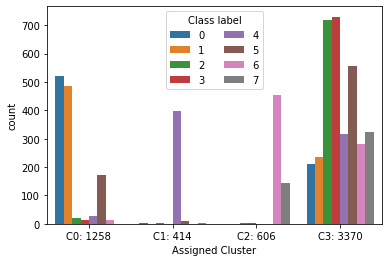

In [162]:
# Make cluster labels
cluster_labels = []
for i in range(4):
    cluster_labels.append("C{}: {}".format(i, sum(df_clusters_classes["Assigned Cluster"] == i)))

# Plot the countplot
ax = sns.countplot(x="Assigned Cluster", hue="Class", data=df_clusters_classes)
ax.legend(title="Class label", loc="upper center", ncol=2)
plt.xticks(np.arange(4), cluster_labels)
plt.show()


**[2.7] (3 points) How does the clustering in Question2:(6) align with the true class labels?
Does it conform to your observations in Question2:(5)?**

I was expecting the 4 clusters to group documents based on their 4 general headings: 'comp', 'rec', 'sci' and 'religion', but this doesn't seem to be the case.

While C0 groups together Class 1 and 2 due to their similar 'comp' heading, the rest of the clusters don't conform to this rule.

C1 and C2 seem to focus on grouping together only one class: Class 4, and 6 respectively.

The biggest surprise is C3, which contains a large number of datapoints from all classes, especially Class 2 and 3.

# Question 3 : (26 points) Logistic Regression Classification
We will now try out supervised classification on this data. We will focus
on Logistic Regression and measure performance in terms of the F1 score
(familiarise yourself with this score which is related to the precision and recall
scores that we learnt about in class).
In most cases, we will need to validate hyper-parameters: to this end, we will use K-
Fold cross validation. Using the provided SKLearn implementation for StratifiedKFold,
create a 10-Fold stratified split of the data. Make sure to set the random state to 0
for reproducibility, and turn on shuffling. We will use the same splits provided by this
throughout this question.

In [235]:
# Create a 10-Fold Stratified Split of the data
skf = StratifiedKFold(n_splits=10, random_state=0, shuffle=True)

#for train_index, test_index in skf.split(NG_train_samples, NG_train_labels):
#    print("TRAIN:", train_index, "TEST:", test_index)
#    X_train, X_test = NG_train_samples.iloc[train_index], NG_train_samples.iloc[test_index]
#    y_train, y_test = NG_train_labels.iloc[train_index], NG_train_labels.iloc[test_index]

**[3.1] (3 points) What is the F1-score, and why is it preferable to accuracy in our problem?
How does the macro-average work to extend the score to multiclass classification?**

F1-score is a measure of a classifier's accuracy, equal to the harmonic mean of precision and recall. It is preferred to standard accuracy when there are imbalanced classes (as is the case in our problem).

For multiclass clasification, passing the average="macro" parameter will calculate metrics for each label, and find their unweighted mean.


**[3.2] (2 points) As always we start with a simple baseline classifier. Define such a classifier
(indicating why you chose it) and report its performance on the Test set. Use the `macro'
average for the f1_score.**

In [223]:
# Baseline classifier
#import random
print("The baseline classifier (always predicts Class 3 - 'rec.motorcycles') would receive an f1_score of: {:.3f}".
      format(f1_score(NG_test_labels, [3]*len(NG_test_labels), average="macro")))
my_randoms = [random.randint(0, 7) for _ in range(len(NG_test_labels))]
print("The baseline classifier (chooses randomly 0..7) would receive an f1_score of: {:.3f}".
      format(f1_score(NG_test_labels, my_randoms, average="macro")))

The baseline classifier (always predicts Class 3 - 'rec.motorcycles') would receive an f1_score of: 0.029
The baseline classifier (chooses randomly 0..7) would receive an f1_score of: 0.126


The baseline classifier (always predicts Class 3 - 'rec.motorcycles') would receive an f1\_score of: 0.029 on the Test set. I chose this baseline classifier because Class 3 is the most common class in the dataset. 

However, trying it on a random classifier (chooses randomly between 0..7) seems to give a better f1\_score, usually between 0.11 - 0.14.

**[3.3] (3 points) We will now train a LogisticRegression Classifier from SKLearn. By
referring to the documentation, explain how the Logistic Regression model can be applied
to classify multi-class labels as in our case. Hint: Limit your explanation to methods we
discussed in the lectures.**

In the multiclass case, the training algorithm uses the one-vs-rest (OvR) scheme, where a binary problem is fit for each label. In other words, each label K gets its own classifier which predicts whether a sample is K or not-K. Then the softmax function is used to normalize all the labels' probabilities, so that each probability lies between 0 and 1, and the sum of all probabilities is 1.

**[3.4] (4 points) Train a Logistic Regressor on the training data. Set solver=`lbfgs' ,
multi_class=`multinomial' and random_state=0 . Use the Cross-Validation object you
created and report the average validation-set F1-score as well as the standard deviation.
Comment on the result.**

In [239]:
from sklearn.metrics import accuracy_score
lr = LogisticRegression(solver="lbfgs", multi_class="multinomial", random_state=0)
f1_scores = []
accs = []

for train_index, test_index in skf.split(NG_train_samples, NG_train_labels):
    X_train, X_test = NG_train_samples.iloc[train_index], NG_train_samples.iloc[test_index]
    y_train, y_test = NG_train_labels.iloc[train_index], NG_train_labels.iloc[test_index]
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    f1_scores.append(f1_score(y_test, y_pred, average="macro"))
    accs.append(accuracy_score(y_test, y_pred))

f1_scores = np.array(f1_scores)
accs = np.array(accs)
print(f1_scores)
print("Acc score mean: {} and std: {}".format(np.mean(accs), np.std(accs)))
print("F1_score mean: {} and std: {}".format(np.mean(f1_scores), np.std(f1_scores)))


[0.65774445 0.67466674 0.6841788  0.69257054 0.65246249 0.67646608
 0.67678013 0.67848246 0.66531366 0.6312439 ]
Acc score mean: 0.6827042367361285 and std: 0.01350166158539
F1_score mean: 0.6689909262264606 and std: 0.016922045421971926


The average F1\_score for the validation set is 0.668 with a standard deviation of 0.016.

This accuracy is somewhat good and its low standard deviation makes the classifier consistent. Although our logistic regressor performs better than the baseline, an F1\_score of only 0.668 wouldn't be considered good enough for practical use.

**[3.5] (5 points) We will now optimise the Regularisation parameter C using cross-validation.
Train a logistic regressor for different values of C : in each case, evaluate the F1 score on
the training and validation portion of the fold. That is, for each value of C you must
provide the training set and validation-set scores per fold and then compute (and store)
the average of both over all folds. Finally plot the (average) training and validation-set
scores as a function of C . Hint: Use a logarithmic scale for C , spanning 19 samples
between 10 −4 to 10 5.**

array([1.00000000e-04, 3.16227766e-04, 1.00000000e-03, 3.16227766e-03,
       1.00000000e-02, 3.16227766e-02, 1.00000000e-01, 3.16227766e-01,
       1.00000000e+00, 3.16227766e+00, 1.00000000e+01, 3.16227766e+01,
       1.00000000e+02, 3.16227766e+02, 1.00000000e+03, 3.16227766e+03,
       1.00000000e+04, 3.16227766e+04, 1.00000000e+05])

In [273]:
# Train and run the regressor for different values of C, evaluating F1 scores for training and validation sets
C_log_vals = np.arange(-4, 5.01, 0.5)
C_vals = 10 ** (C_log_vals)
avg_training_scores = []
avg_validation_scores = []

# for each value of C
for c in C_vals:
    lr_withC = LogisticRegression(solver="lbfgs", multi_class="multinomial", random_state=0, C=c)
    local_t_score = []
    local_v_score = []
    # Partition training and validation folds
    for train_index, test_index in skf.split(NG_train_samples, NG_train_labels):
        X_train, X_val = NG_train_samples.iloc[train_index], NG_train_samples.iloc[test_index]
        y_train, y_val = NG_train_labels.iloc[train_index], NG_train_labels.iloc[test_index]
        # Fit the classifier
        lr_withC.fit(X_train, y_train)
        
        # Get score on training data
        y_pred = lr_withC.predict(X_train)
        local_t_score.append(f1_score(y_train, y_pred, average="macro"))
        
        # Get score on validation data
        y_pred = lr_withC.predict(X_val)                     
        local_v_score.append(f1_score(y_val, y_pred, average="macro"))
    # add average F1
    avg_training_scores.append(np.mean(np.array(local_t_score)))
    avg_validation_scores.append(np.mean(np.array(local_v_score)))

/home/valentine/miniconda3/envs/iamlassignment2/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/valentine/miniconda3/envs/iamlassignment2/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/valentine/miniconda3/envs/iamlassignment2/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/valentine/miniconda3/envs/iamlassignment2/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels wi

/home/valentine/miniconda3/envs/iamlassignment2/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/valentine/miniconda3/envs/iamlassignment2/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/valentine/miniconda3/envs/iamlassignment2/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/valentine/miniconda3/envs/iamlassignment2/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels wi

/home/valentine/miniconda3/envs/iamlassignment2/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/valentine/miniconda3/envs/iamlassignment2/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/valentine/miniconda3/envs/iamlassignment2/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/valentine/miniconda3/envs/iamlassignment2/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels wi

/home/valentine/miniconda3/envs/iamlassignment2/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/valentine/miniconda3/envs/iamlassignment2/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/valentine/miniconda3/envs/iamlassignment2/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/valentine/miniconda3/envs/iamlassignment2/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels wi

/home/valentine/miniconda3/envs/iamlassignment2/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/valentine/miniconda3/envs/iamlassignment2/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/valentine/miniconda3/envs/iamlassignment2/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/valentine/miniconda3/envs/iamlassignment2/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/valentine/miniconda3/envs/iamlassignment2/lib/python3.

/home/valentine/miniconda3/envs/iamlassignment2/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/valentine/miniconda3/envs/iamlassignment2/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/valentine/miniconda3/envs/iamlassignment2/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/valentine/miniconda3/envs/iamlassignment2/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/valentine/miniconda3/envs/iamlassignment2/lib/python3.

/home/valentine/miniconda3/envs/iamlassignment2/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/valentine/miniconda3/envs/iamlassignment2/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/valentine/miniconda3/envs/iamlassignment2/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/valentine/miniconda3/envs/iamlassignment2/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/valentine/miniconda3/envs/iamlassignment2/lib/python3.

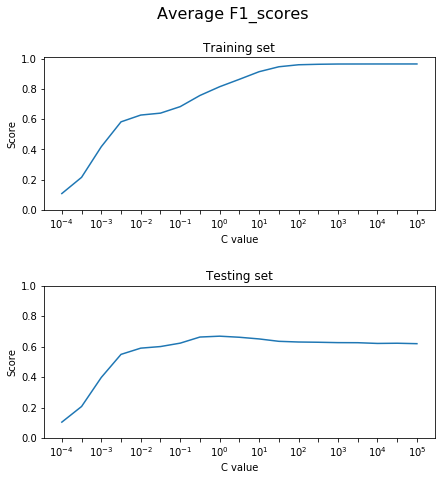

In [348]:
# Plot average training and validation scores as a fuction of C

# Put average scores in a DataFrame
df_F1_training = pd.DataFrame(index=C_vals, data=avg_training_scores, columns=["Average F1_score"])
df_F1_validation =pd.DataFrame(index=C_vals, data=avg_validation_scores, columns=["Average F1_score"])

# Plot figure
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7,7))
fig.suptitle('Average F1_scores', size=16)
fig.subplots_adjust(hspace = 0.5)

# Plot subplot 1 (training set scores)
sns.lineplot(data=df_training, x=df_F1_training.index, y="Average F1_score", ax=ax1)
ax1.set_title("Training set", size=12)
ax1.set_xlabel("C value")
ax1.set_ylabel("Score")
ax1.set_yticks(np.arange(0.0, 1.01, 0.2))
ax1.set_xscale('log')
ax1.set_xticks(C_vals)

# Plot subplot 2 (validation set scores)
sns.lineplot(data=df_validation, x=df_F1_validation.index, y="Average F1_score", ax=ax2)
ax2.set_title("Testing set", size=12)
ax2.set_xlabel("C value")
ax2.set_ylabel("Score")
ax2.set_yticks(np.arange(0.0, 1.01, 0.2))
ax2.set_xscale('log')
ax2.set_xticks(C_vals)

plt.show()

**[3.6] (7 points) What is the optimal value of C (and the corresponding score)? How did
you choose this value? By making reference to the effect of the regularisation parameter
C on the optimisation, explain what is happening in your plot from Question 3:(5) Hint:
Refer to the documentation for C in the LogisticRegression page on SKLearn.**

The optimal value of C is 1.0, which corresponds to a score of 0.668 on the validation set and 0.817 on the training set. This value gives us the highest score on the validation set, meaning it generalizes best on unseen data.

According to the SKLearn documentation, C value is the "Inverse of regularization strength". In other words, it controls how flexible our regressor is. Increasing the C value too much results in overfitting, because our model tries too hard to capture the noise in our training set. This can be seen in our plot, where the model overfits after a value of C = 1.0.

**[3.7] (2 points) Finally, report the score of the best model on the test-set, after retraining
on the entire training set (that is drop the folds). Hint: You may need to set max_iter
= 200 . Comment briefly on the result.**

In [351]:
# Retrain the best model
lr_best = LogisticRegression(solver="lbfgs", multi_class="multinomial", random_state=0, C=1.0, max_iter=200)
lr_best.fit(NG_train_samples, NG_train_labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [357]:
y_pred = lr_best.predict(NG_test_samples)
print("F1_Score on Testing set: {:.3f}".format(f1_score(NG_test_labels, y_pred, average="macro")))

F1_Score on Testing set: 0.675
